In [1]:
import time
from collections import deque
from enum import Enum
from IPython import display

import random
from typing import SupportsFloat, Any
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import gymnasium as gym
from gymnasium import spaces
from gymnasium.core import RenderFrame, ActType, ObsType
from pytorch_grad_cam import GradCAM
from scipy.stats import ks_2samp

from GradCam import GradCam
from torchvision.models import resnet101, resnet50
from utils import image_net_postprocessing
import numpy as np
from torchvision import transforms
import os
import glob
from PIL import Image
import PIL
import json
from pathlib import Path
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
import torch.optim as optim
import tianshou as ts
from tianshou.utils import WandbLogger
from torch.utils.tensorboard import SummaryWriter
from gymnasium.wrappers import TimeLimit
import einops

/home/behnamnia/.conda/envs/rl39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/behnamnia/.conda/envs/rl39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

## Dataset

In [3]:
ts.trainer.base.BaseTrainer

tianshou.trainer.base.BaseTrainer

In [4]:
class COCODataset(D.Dataset):
    def __init__(self, root, train=True):
        root = Path(root)

        with open(root/'annotations/captions_train2017.json', 'r') as f:
            images_info = json.load(f)
        self.file_name_to_id = dict()
        for image_info in images_info['images']:
            self.file_name_to_id[image_info['file_name']] = image_info['id']

        with open(root/'cap_dict.json', 'r') as f:
            self.captions_dict = json.load(f)

        if train:
            self.image_files = glob.glob(os.path.join(root/'train2017', "*.jpg"))
        else:
            self.image_files = glob.glob(os.path.join(root/'val2017', "*.jpg"))

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image = PIL.Image.open(image_file)
        image = image.convert('RGB')
        file_name = image_file.split('/')[-1]
        image_tensor = transforms.ToTensor()(image)

        return image_tensor, self.file_name_to_id[file_name]

    def __len__(self):
        return len(self.image_files)

## Environment

In [5]:
class ResnetGradCam(torch.nn.Module):
    def __init__(self, patch_size):
        super(ResnetGradCam, self).__init__()
        feature_extractor = resnet50(pretrained=True).to(device).eval()
        self.vis = GradCam(feature_extractor, device)
        self.patch_size = patch_size
        self.conv_mean = nn.Conv2d(1, 1, kernel_size=self.patch_size, stride=self.patch_size, padding=0,  bias=False)
        self.conv_mean.weight = torch.nn.Parameter(torch.ones_like(self.conv_mean.weight)  / (patch_size[0] * patch_size[1]))

    def forward(self, x, h, w):
        '''
        return the row/col number of a single patch chosen randomly based on the gradcam score
        '''
        self.vis(x, None, postprocessing=image_net_postprocessing)
        self.vis.cam -= torch.min(self.vis.cam)
        self.vis.cam /= torch.max(self.vis.cam)
        resized_cam = transforms.Resize(size=(h, w))(self.vis.cam.unsqueeze(0).unsqueeze(0))

        number_of_rows = (h - self.patch_size[0]) // self.patch_size[0] + 1
        number_of_cols = (w - self.patch_size[1]) // self.patch_size[1] + 1

        scores = self.conv_mean(resized_cam)

        choice = torch.multinomial(scores.flatten(), 1).item()

        row_choice, col_choice = choice // number_of_cols, choice % number_of_cols

        return torch.tensor([[row_choice, col_choice]])

In [6]:
class Actions(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3
    # STAY = 4

In [7]:
class Environment(gym.Env):
    metadata = {"render_modes": ["rgb_array"], "render_fps": 4}

    def __init__(self, dataloader, patch_size=(64, 64), input_size=224):
        self.dataloader = dataloader
        self.iterator = iter(dataloader)
        self.transform = transforms.Resize(input_size)
        self.patch_size = patch_size

        self.observation_space = spaces.Box(low=0, high=255, shape=(3, self.patch_size[0], self.patch_size[1]), dtype=np.uint8)
        self.action_space = spaces.Discrete(len(Actions))

        self.row, self.col, self.max_row, self.max_col = None, None, None, None
        self.height, self.width = None, None
        self.current_image, self.image_id, self.captions = None, None, None
        self.axis_image_render = None

        # self.grad = ResnetGradCam(patch_size).to(device).eval()

        self.reset()

    def reset(self, **kwargs):
        try:
            # Samples the batch
            self.current_image, self.image_id = next(self.iterator)
        except StopIteration:
            # restart the iterator if the previous iterator is exhausted.
            self.iterator = iter(self.dataloader)
            self.current_image, self.image_id = next(self.iterator)

        self.current_image = self.current_image
        self.image_id = str(self.image_id.item())
        _, _, self.height, self.width = self.current_image.shape
        self.captions = self.dataloader.dataset.captions_dict[self.image_id]
        self.max_row, self.max_col = (self.height - self.patch_size[0]) // self.patch_size[0], (self.width - self.patch_size[1]) // self.patch_size[1]

        # self.row, self.col = [int(x) for x in self.grad(self.transform(self.current_image.to(device)), self.height, self.width)[0]] # just a single row/col
        self.row, self.col = self.max_row//2, self.max_col//2

        return self._get_patch(), {}

    def _get_patch(self):
        start_row, end_row = self.row * self.patch_size[0], (self.row + 1) * self.patch_size[0]
        start_col, end_col = self.col * self.patch_size[1], (self.col + 1) * self.patch_size[1]
        return self.current_image[0, :, start_row: end_row, start_col: end_col]


    def step(self, action):
        if Actions(action) == Actions.UP:
            self.row = self.row - 1 if self.row > 0 else self.row
        elif Actions(action) == Actions.RIGHT:
            self.col = self.col + 1 if self.col < self.max_col else self.col
        elif Actions(action) == Actions.DOWN:
            self.row = self.row + 1 if self.row < self.max_row else self.row
        elif Actions(action) == Actions.LEFT:
            self.col = self.col - 1 if self.col > 0 else self.col
        else:
            raise ValueError("Invalid action")

        patch = self._get_patch()
        return patch, 0, False, False, {}

    def _get_render_image(self):
        start_row, end_row = self.row * self.patch_size[0], (self.row + 1) * self.patch_size[0]
        start_col, end_col = self.col * self.patch_size[1], (self.col + 1) * self.patch_size[1]
        image = einops.rearrange(self.current_image.squeeze(), 'c h w -> h w c')
        image[start_row: end_row, start_col: end_col] = 0.8 * image[start_row: end_row, start_col: end_col]
        return image

    def render(self):
        if self.axis_image_render is None:
            self.axis_image_render = plt.imshow(self._get_render_image())
        else:
            self.axis_image_render.set_data(self._get_render_image())
            display.display(plt.gcf())
            display.clear_output(wait=True)


In [8]:
# env = gym.make('Breakout-v0')
# env.reset()
# img = plt.imshow(env.render(mode='rgb_array')) # only call this once
# for _ in range(100):
#     img.set_data(env.render(mode='rgb_array')) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action = env.action_space.sample()
#     env.step(action)

In [9]:
class Q_network(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.feature_extractor = resnet50(pretrained=True)
        input_dim = self.feature_extractor.fc.out_features
        action_shape = train_envs.get_env_attr('action_space',0)[0].n
        self.dueling_head = ts.utils.net.common.Net(input_dim, action_shape, dueling_param=(
            {
                "input_dim": 1024,
                "output_dim": action_shape,
                "hidden_sizes": [512, 512],
            },
            {
                "input_dim": 1024,
                "output_dim": 1,
                "hidden_sizes": [512, 512],
            }
        ), hidden_sizes=[1024],)

    def forward(self, obs, **kwargs):
        obs = torch.tensor(obs)
        duel_out = self.dueling_head(self.feature_extractor(obs))
        return duel_out

In [10]:
lr, epoch, batch_size = 1e-3, 10, 8
test_num = 10
gamma, n_step, target_freq = 0.9, 3, 320
buffer_size = 20000
eps_train, eps_test = 0.1, 0.05
step_per_epoch, step_per_collect = 100, 10

In [11]:
dataset = COCODataset(root="../Data/COCO17")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [12]:
train_envs = ts.env.DummyVectorEnv([lambda: TimeLimit(Environment(dataloader), 100) for _ in range(1)])
test_envs = ts.env.DummyVectorEnv([lambda: TimeLimit(Environment(dataloader), 100) for _ in range(1)])

In [13]:
net = Q_network()
optim = torch.optim.Adam(net.parameters(), lr=lr)
policy = ts.policy.DQNPolicy(net, optim, discount_factor=gamma, estimation_step=n_step, target_update_freq=target_freq)
replay_buffer = ts.data.VectorReplayBuffer(buffer_size, len(train_envs))
train_collector = ts.data.Collector(policy, train_envs, replay_buffer)
test_collector = ts.data.Collector(policy, test_envs)

/home/behnamnia/.conda/envs/rl39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/behnamnia/.conda/envs/rl39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
logger = WandbLogger(
    train_interval=1,
    test_interval=1,
    update_interval=1,
    project="AttentionRL",
    name="testname",
)
logger.load(SummaryWriter("./logs"))

result = ts.trainer.offpolicy_trainer(
    policy=policy, train_collector=train_collector,test_collector=None, episode_per_test=test_num, max_epoch=epoch, step_per_epoch=step_per_epoch, step_per_collect=step_per_collect,
    batch_size=batch_size, update_per_step=1 / step_per_collect,
    train_fn=lambda epoch, env_step: policy.set_eps(eps_train),
    test_fn=lambda epoch, env_step: policy.set_eps(eps_test),
    stop_fn=lambda mean_rewards: mean_rewards >= 0,
    logger=logger
)

/home/behnamnia/.conda/envs/rl39/lib/python3.9/site-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: attentionrl. Use `wandb login --relogin` to force relogin
fatal: unable to create temp-file: Permission denied
/home/behnamnia/.conda/envs/rl39/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:70: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Epoch #1: 101it [00:10,  9.23it/s, env_step=100, len=100, loss=4.182, n/ep=1, n/st=10, rew=0.00]
Epoch #2: 101it [00:07, 13.92it/s, env_step=200, len=100, loss=2.262, n/ep=1, n/st=10, rew=0.00]
Epoch #3: 101it [00:08, 12.33it/s, env_step=300, len=100, loss=1.577, n/ep=1, n/st=10, rew=0.00]
Epoch #4:  30%|3| 30/100 [00:02<00:05, 13.59it/s, env_step=320, len=100, loss=1.


KeyboardInterrupt: 

KeyboardInterrupt: 

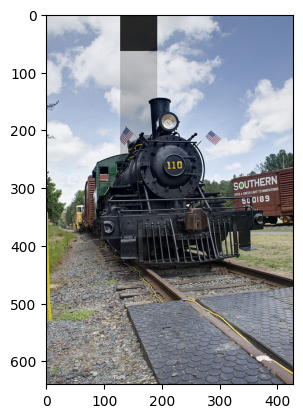

In [22]:
policy.eval()
policy.set_eps(eps_test)
env = TimeLimit(Environment(dataloader), 100)
collector = ts.data.Collector(policy, env, exploration_noise=True)
collector.collect(n_episode=2, render=1 / 35)

In [23]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from transformers import SamModel, SamProcessor, pipeline
import gc

from PIL import Image
import requests

In [24]:
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")

/home/behnamnia/.conda/envs/rl39/lib/python3.9/site-packages/transformers/modeling_utils.py:1825: DeprecationWarning: invalid escape sequence \d
  reg = re.compile("(.*?)-\d{5}-of-\d{5}")


KeyboardInterrupt: 

In [21]:
for img in dataset:
    image = transforms.ToPILImage()(img[0])

    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits
    result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[img[0].shape[2:0:-1]])
    plt.imshow(image)
    plt.show()
    plt.imshow(result[0]['segmentation'])
    plt.show()

NameError: name 'processor' is not defined

In [24]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for mask in masks:
        show_mask(mask, ax=ax, random_color=True)
    plt.axis("off")
    plt.show()
    del mask
    gc.collect()


In [25]:
generator = pipeline("mask-generation", model="facebook/sam-vit-huge")

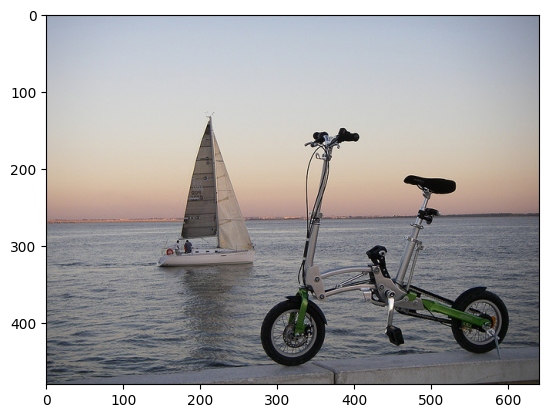

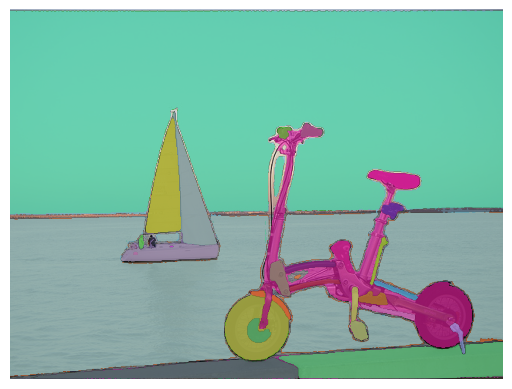

KeyboardInterrupt: 

In [26]:
for img in dataset:
    image = transforms.ToPILImage()(img[0])

    with torch.no_grad():
        outputs = generator(image, points_per_batch=64)

    plt.imshow(image)
    plt.show()
    show_masks_on_image(image, outputs['masks'])
    plt.show()


In [37]:
type(outputs['masks'][0])

numpy.ndarray